# Catboost

CatBoost is a high-performance open source library for gradient boosting on decision trees. Source: [CatBoost](https://catboost.ai/)

## Introduction

We weren’t making any improvements and we had ran out of ideas, however we noticed that we could achieve a higher score in the ranking, as people had higher score. So we decided to ask ChatGPT for advice. After several questions, we concluded that one of the options was to try new models and the one that convinced us the most was CatBoost. In addition, it suggested that we could use Optuna to search the hyperparameters.

CatBoost is an algorithm for gradient boosting on decision trees. We have already used gradient boosting models, but this implementation is optimized for categorical features. It is also optimized for speed and performance, and it is able to handle large datasets with ease. It is also able to handle missing values and it is able to handle categorical features without the need for one-hot encoding.

## Methodology

First, as we didn't know anything about CatBoost we had to read the documentation and some tutorials. We also had to read the Optuna documentation to understand how to use it. 

We tried to use the same dataset and features that we used in the previous models with a satisfactory result but it wasn't enough to improve our score. So we decided to use different datasets: the one we used in the previous models, that one but with one-hot encoding, another removing outliers and the same but with one-hot encoding. We didn't get good results, or at least as good as we were expecting.

To execute the models, we decided to implement two models, one per target variable. Although we didn't really high results when we tried this technique with Random Forest, we still think it is a good approach. We also used Optuna to search the hyperparameters for each one.

## Implementation

In [ ]:
# import libraries

import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

import pandas as pd
import numpy as np
import json

from sklearn.model_selection import train_test_split
from mlflow.create_dataset import Dataset
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
# load data
data = Dataset()
X, y, output = data.all_onehot()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
h1_train = y_train["h1n1_vaccine"]
seasonal_train = y_train["seasonal_vaccine"]
h1_test = y_test["h1n1_vaccine"]    
seasonal_test = y_test["seasonal_vaccine"]

Optuna needs a function to optimize, so we created a function that receives the type of target variable and returns the best roc auc score.

In [ ]:
def objective_vaccine(trial, target):
    '''Objective function for Optuna study to optimize CatBoost hyperparameters for vaccine prediction.
    '''
    param_dist_random = {
        'iterations': trial.suggest_int('iterations', 100, 3000),
        'depth': trial.suggest_int('depth', 4, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
    }

    if target == 'h1n1_vaccine': #change target
        target_data = h1_train
    elif target == 'seasonal_vaccine':
        target_data = seasonal_train
    else:
        raise ValueError(f"Unknown target column: {target}")
    
    class_majority = target_data.value_counts().max()  
    class_minority = target_data.value_counts().min()  

    # Calcular los pesos de las clases
    class_weight_majority = len(target_data) / (2 * class_majority)
    class_weight_minority = len(target_data) / (2 * class_minority)

    model = CatBoostClassifier(
        eval_metric='AUC',        
        cat_features=[],
        train_dir='catboost_info',
        class_weights=[class_weight_majority, class_weight_minority],    
        early_stopping_rounds=50, verbose=0, **param_dist_random         
    )
    # Inicializar StratifiedKFold para validación cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    auc_scores = []  # Para almacenar AUC de cada pliegue
    X_train.reset_index(drop=True, inplace=True)
    target_data.reset_index(drop=True, inplace=True)

    for train_index, val_index in cv.split(X_train, target_data):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = target_data.iloc[train_index], target_data.iloc[val_index]

        # Entrenar el modelo en cada pliegue
        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), use_best_model=True)

        # Obtener las predicciones para el conjunto de validación
        y_pred_prob = model.predict_proba(X_val_fold)[:, 1]

        # Calcular AUC para el pliegue
        auc = roc_auc_score(y_val_fold, y_pred_prob)
        auc_scores.append(auc)

    # Promediar las AUC de todos los pliegues
    mean_auc = np.mean(auc_scores)

    return float(mean_auc)

In [3]:
################ Start Optuna Seasonal vaccine ################
#study_s = optuna.create_study(directions=["maximize"]) # maximize the AUC
#study_s.optimize(lambda trial: objective_vaccine(trial, target='seasonal_vaccine'), n_trials=100, show_progress_bar=True)

study_s = {"best_params":{"bagging_temperature":  0.853866509451896, "border_count": 127,
"depth":5, "grow_policy": "Lossguide", "iterations": 1824, "l2_leaf_reg":  0.31016355711364624, "learning_rate":  0.021012990831275884, "loss_function": "CrossEntropy", "random_strength": 0.4969828250778662}, "best_value":0.86510516892383}
print("Seasonal done")
print(study_s["best_params"])
print(study_s["best_value"])

# results = {
#     "best_params": study_s.best_params,
#     "best_value": study_s.best_value
# }

# with open("seasonal_vaccine_results.json", "w") as f: # save the results in case of failure
#     json.dump(results, f, indent=4)

Seasonal done
{'bagging_temperature': 0.853866509451896, 'border_count': 127, 'depth': 5, 'grow_policy': 'Lossguide', 'iterations': 1824, 'l2_leaf_reg': 0.31016355711364624, 'learning_rate': 0.021012990831275884, 'loss_function': 'CrossEntropy', 'random_strength': 0.4969828250778662}
0.86510516892383


In [4]:
################ Start Optuna h1n1 vaccine ################
#study_h1 = optuna.create_study(directions=["maximize"])
#study_h1.optimize(lambda trial: objective_vaccine(trial, target='h1n1_vaccine'), n_trials=100, show_progress_bar=True)  

study_h1 = {"best_params":{"bagging_temperature": 0.30983176219520503, "border_count": 134, "depth": 
6, "grow_policy": "Lossguide", "iterations": 2779, "l2_leaf_reg": 7.50192142172408, "learning_rate": 0.006885816530257467, "loss_function": "Logloss", "random_strength":1.414598986662248}, "best_value": 0.8707217427565673} 

print("H1N1 done")
print(study_h1["best_params"])
print(study_h1["best_value"])

# results = {
#     "best_params": study_h1.best_params,
#     "best_value": study_h1.best_value
# }

# with open("h1_vaccine_results.json", "w") as f: # save the results in case of failure
#     json.dump(results, f, indent=4)

H1N1 done
{'bagging_temperature': 0.30983176219520503, 'border_count': 134, 'depth': 6, 'grow_policy': 'Lossguide', 'iterations': 2779, 'l2_leaf_reg': 7.50192142172408, 'learning_rate': 0.006885816530257467, 'loss_function': 'Logloss', 'random_strength': 1.414598986662248}
0.8707217427565673


In [5]:
# fit models with best parameters
model0 = CatBoostClassifier(**study_h1["best_params"])
model1 = CatBoostClassifier(**study_s["best_params"])

model0.fit(X_train, h1_train, early_stopping_rounds=50, verbose=100)
model1.fit(X_train, seasonal_train, early_stopping_rounds=50, verbose=100)

0:	learn: 0.6878328	total: 140ms	remaining: 6m 29s
100:	learn: 0.4447284	total: 2.38s	remaining: 1m 2s
200:	learn: 0.3842777	total: 4.46s	remaining: 57.3s
300:	learn: 0.3627001	total: 6.64s	remaining: 54.6s
400:	learn: 0.3518884	total: 8.66s	remaining: 51.3s
500:	learn: 0.3449091	total: 10.7s	remaining: 48.5s
600:	learn: 0.3398456	total: 12.7s	remaining: 45.8s
700:	learn: 0.3357366	total: 14.6s	remaining: 43.3s
800:	learn: 0.3323286	total: 16.5s	remaining: 40.8s
900:	learn: 0.3293522	total: 18.5s	remaining: 38.6s
1000:	learn: 0.3269275	total: 20.4s	remaining: 36.3s
1100:	learn: 0.3246178	total: 22.4s	remaining: 34.1s
1200:	learn: 0.3222707	total: 24.3s	remaining: 31.9s
1300:	learn: 0.3199167	total: 26.2s	remaining: 29.8s
1400:	learn: 0.3175158	total: 28.1s	remaining: 27.7s
1500:	learn: 0.3147005	total: 30.2s	remaining: 25.7s
1600:	learn: 0.3115932	total: 32.3s	remaining: 23.8s
1700:	learn: 0.3081273	total: 34.5s	remaining: 21.9s
1800:	learn: 0.3046960	total: 36.6s	remaining: 19.9s
1900

In [14]:
y_test

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
17370,1,1
6732,0,1
10644,0,0
4807,0,0
17090,1,1
...,...,...
2623,0,0
25269,0,1
3546,1,1


In [12]:
# extract predictions
y_pred0 = model0.predict(X_test)
y_pred1 = model1.predict(X_test)
y_pred_prob0 = model0.predict_proba(X_test)
y_pred_prob1 = model1.predict_proba(X_test)

y_pred = np.column_stack([y_pred0, y_pred1])

In [7]:
################ METRICS ################
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'F1: {f1}')

Accuracy: 0.6868214152002995
ROC AUC: 0.7546046843692666
F1: 0.6805882143166997


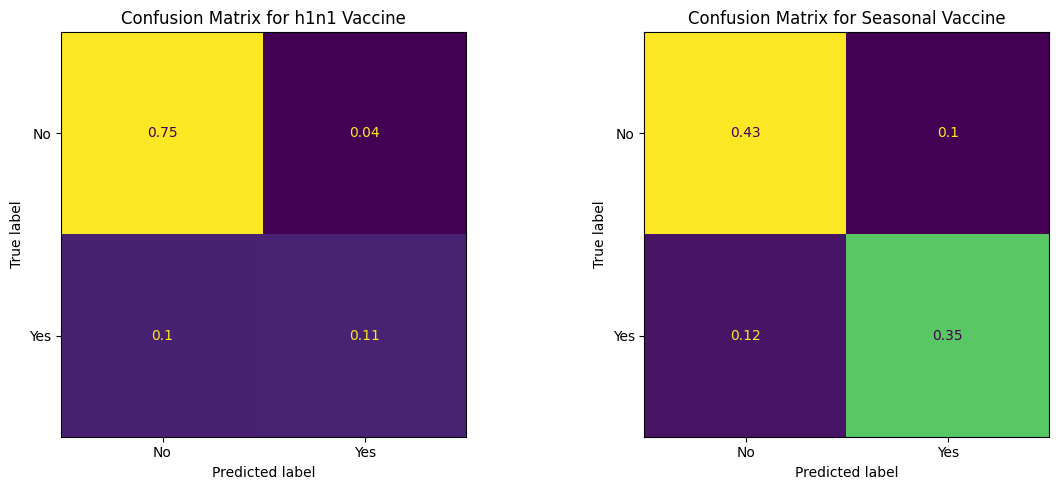

In [ ]:
# confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# H1N1 vaccine
cm_h1n1 = confusion_matrix(y_test['h1n1_vaccine'], y_pred0, normalize='all')
disp_h1n1 = ConfusionMatrixDisplay(confusion_matrix=cm_h1n1, display_labels=['No', 'Yes'])
disp_h1n1.plot(ax=ax[0], colorbar=False)
ax[0].set_title('Confusion Matrix for h1n1 Vaccine')

# Confusion matrix for seasonal vaccine
cm_seasonal = confusion_matrix(y_test['seasonal_vaccine'], y_pred1, normalize='all')
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal, display_labels=['No', 'Yes'])
disp_seasonal.plot(ax=ax[1], colorbar=False)
ax[1].set_title('Confusion Matrix for Seasonal Vaccine')

plt.tight_layout()
plt.show()

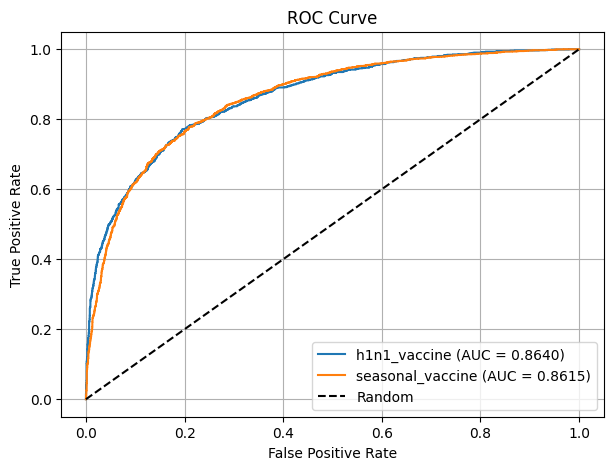

In [ ]:
y_scores = [p[:, 1] for p in [y_pred_prob0, y_pred_prob1]]

plt.figure(figsize=(7, 5))
for i, y_score in enumerate(y_scores):
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_score)
    auc = roc_auc_score(y_test.iloc[:, i], y_score)
    plt.plot(fpr, tpr, label=f'{y_test.columns[i]} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Submission

In [ ]:
predictions0 = model0.predict_proba(output)
predictions1 = model1.predict_proba(output)

h1n1_probs = predictions0[:, 1]  
seasonal_probs = predictions1[:, 1] 

predict = pd.DataFrame({
    "respondent_id": output.index,
    "h1n1_vaccine": h1n1_probs,
    "seasonal_vaccine": seasonal_probs
})
predict.set_index("respondent_id", inplace=True)

In [ ]:
# predict.to_csv("predictions.csv")

## Results

Executing Catboost could be a little bit slow some times from 2 to 9 hours, but it is worth it. We got a better score than the previous models. The tests with the tag selected are the ones tested on the competion page. Some runs don't have a roc auc score because we forgot to save it, but anyways it's just the mean of the two other values.

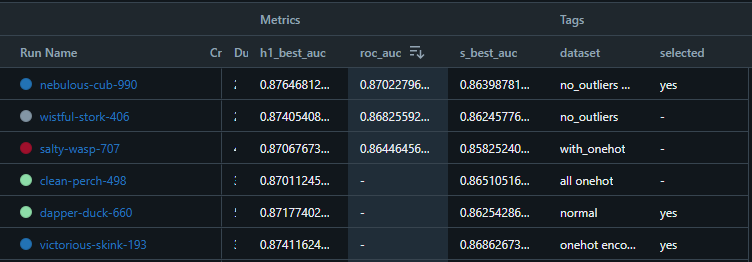

Results of the models with the tag selected:

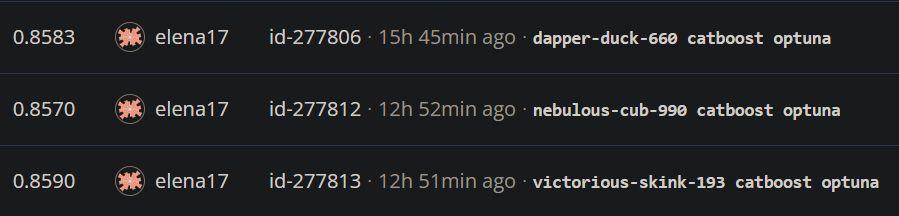

All of the models have lower scores on the competition page than the ones we got in the local tests. This might mean that the model is a bit overfitted or that the competition dataset has some differences from the one we used to train and our model wasn't able to generalize well.

Now we will explain a bit more about each run:
* dapper-duck-660: This was the first run we did. The dataset used was the one we used in the previous models. We got a good score, but we thought we could get a better one.
* nebulous-cub-990: This was the second run we did. The dataset used was one without outliers and with one-hot encoding. Surprisingly, we got a lower score than the previous run although it performed better in the local tests.
* victorious-skink-193: That day we had an extra opportunity into the competition, so we decided to try another dataset. In this case, it's the same dataset as dapper-duck-660 but with one-hot encoding. We got a better score than the previous runs.

We think the improvement isn't only based on the dataset but also on the train-test split and of course the hyperparameter seach that is not deterministic. On a second thought, it might have been better to set a deterministic seed.